### IMPORT LIBRARIES

In [ ]:
# Import libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib  
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from prophet import Prophet

### LOAD DATASET AND VIEW

In [2]:
#Load Dataset
df = pd.read_csv("walmart_sales_cleaned.csv")
df.head()


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Date,Week_num,Year
0,1,"$1,643,690.90",0,42.31,2.572,211.096358,8.106,5/2/2010,19,2010
1,1,"$1,641,957.44",1,38.51,2.548,211.242170,8.106,12/2/2010,49,2010
2,1,"$1,611,968.17",0,39.93,2.514,211.289143,8.106,2/19/2010,8,2010
3,1,"$1,409,727.59",0,46.63,2.561,211.319643,8.106,2/26/2010,9,2010
4,1,"$1,554,806.68",0,46.50,2.625,211.350143,8.106,5/3/2010,19,2010


### PREPARING THE DATA

In [3]:
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])
# Add month to columns
df['Month'] = df['Date'].dt.month
df = df.sort_values('Date').reset_index(drop=True)

# Convert Weekly sales to numeric
df['Weekly_Sales'] = pd.to_numeric(
    df['Weekly_Sales'].str.replace(r'[$,]', '', regex=True)
)


### SUMMARIZING NUMERICAL VARIABLES

In [4]:
# Basic summary
subset = df[['Weekly_Sales','Holiday_Flag', 'Fuel_Price', 'CPI', 'Unemployment']]
print(subset.describe())


       Weekly_Sales  Holiday_Flag   Fuel_Price          CPI  Unemployment
count  6.435000e+03   6435.000000  6435.000000  6435.000000   6435.000000
mean   1.046965e+06      0.069930     3.358607   171.578394      7.999151
std    5.643666e+05      0.255049     0.459020    39.356712      1.875885
min    2.099862e+05      0.000000     2.472000   126.064000      3.879000
25%    5.533501e+05      0.000000     2.933000   131.735000      6.891000
50%    9.607460e+05      0.000000     3.445000   182.616521      7.874000
75%    1.420159e+06      0.000000     3.735000   212.743293      8.622000
max    3.818686e+06      1.000000     4.468000   227.232807     14.313000


### EXPLORATORY ANALYSIS

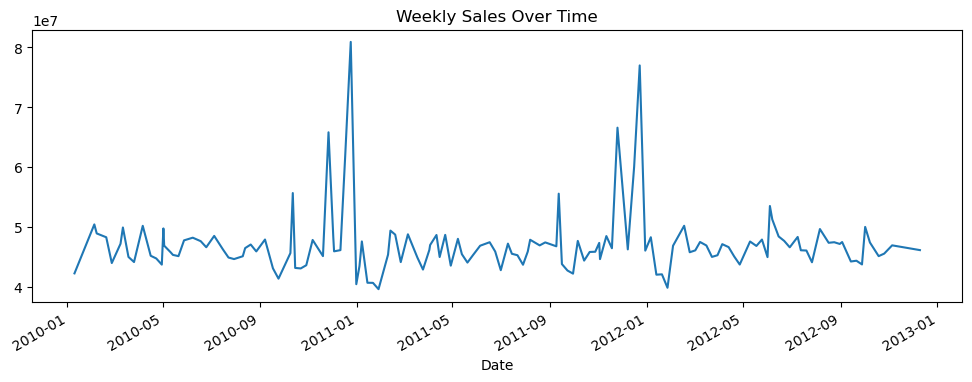

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot weekly sales over time
df.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(12,4))
plt.title("Weekly Sales Over Time")
plt.show()

# Save as PNG 
plt.savefig('weekly_sales.png', dpi=300, bbox_inches='tight')

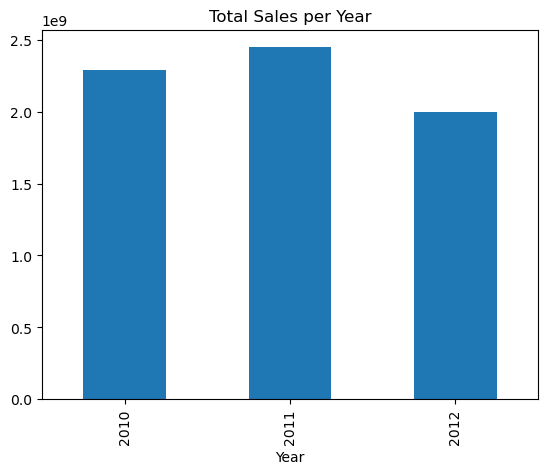

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot weekly sales by year
df.groupby('Year')['Weekly_Sales'].sum().plot(kind='bar')
plt.title("Total Sales per Year")
plt.show()

# Save as PNG 
plt.savefig('yearly_sales.png', dpi=300, bbox_inches='tight')

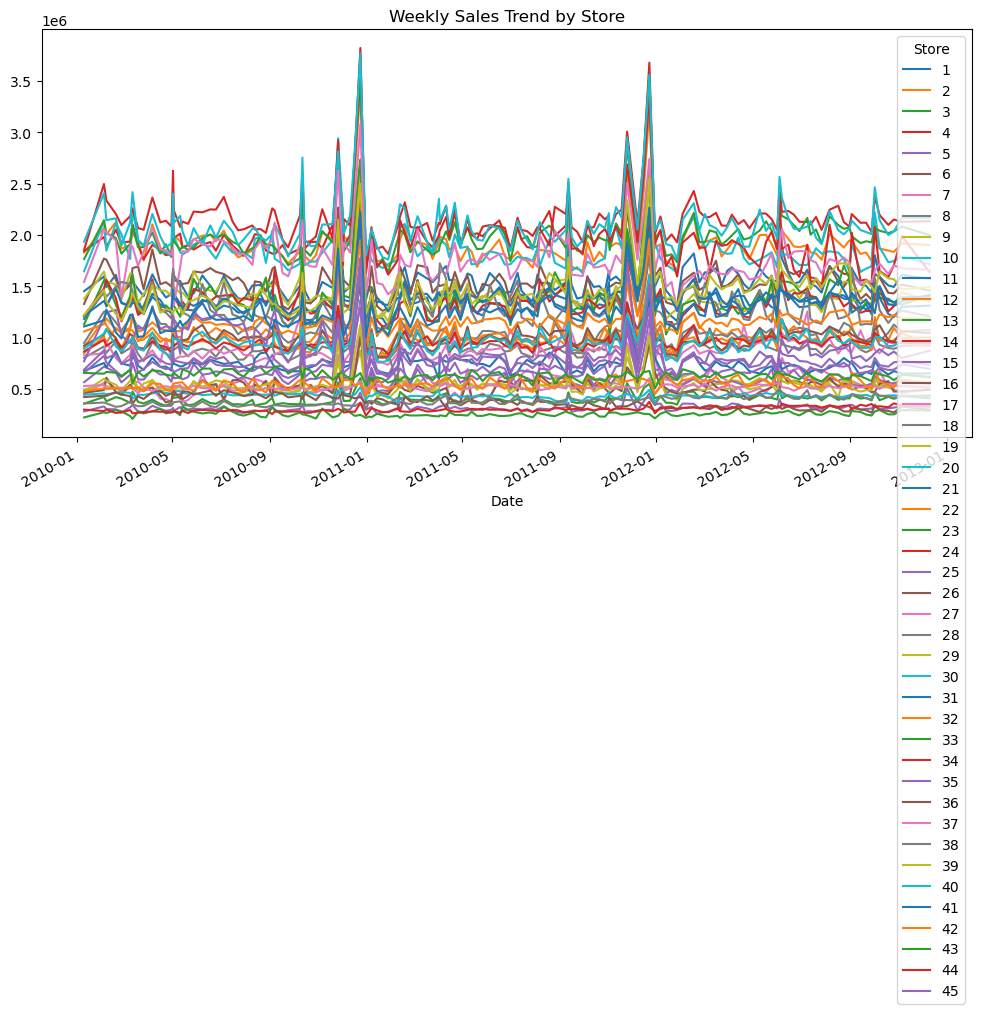

<Figure size 640x480 with 0 Axes>

In [7]:
# Weekly trend by store 
df.groupby(['Date','Store'])['Weekly_Sales'].sum().unstack().plot(figsize=(12,6))
plt.title("Weekly Sales Trend by Store")
plt.show()
# Save as PNG 
plt.savefig('store_trend.png', dpi=300, bbox_inches='tight')

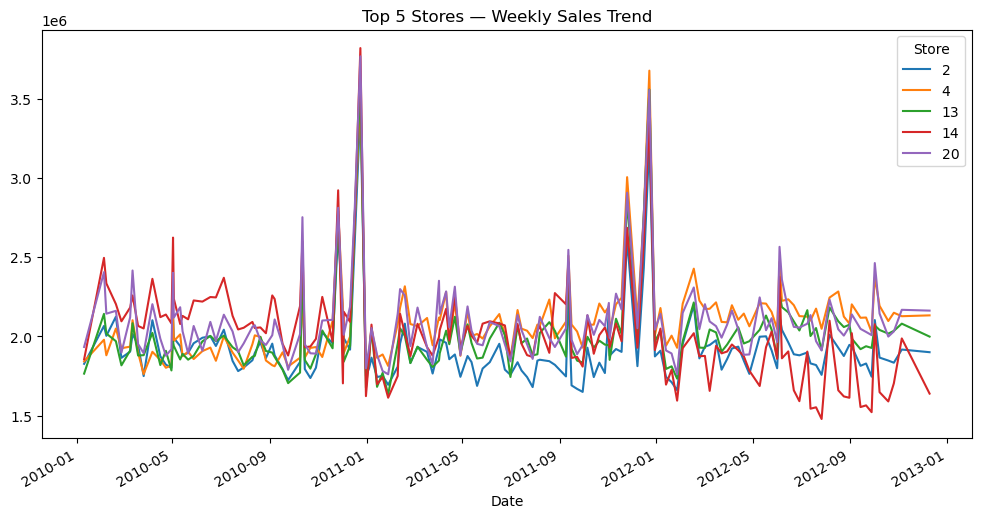

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot top 5 stores
top5 = df.groupby('Store')['Weekly_Sales'].sum().nlargest(5).index

df[df['Store'].isin(top5)] \
    .pivot(index='Date', columns='Store', values='Weekly_Sales') \
    .plot(figsize=(12,6))
plt.title("Top 5 Stores — Weekly Sales Trend")
plt.show()

# Save as PNG 
plt.savefig('top_5_stores.png', dpi=300, bbox_inches='tight')


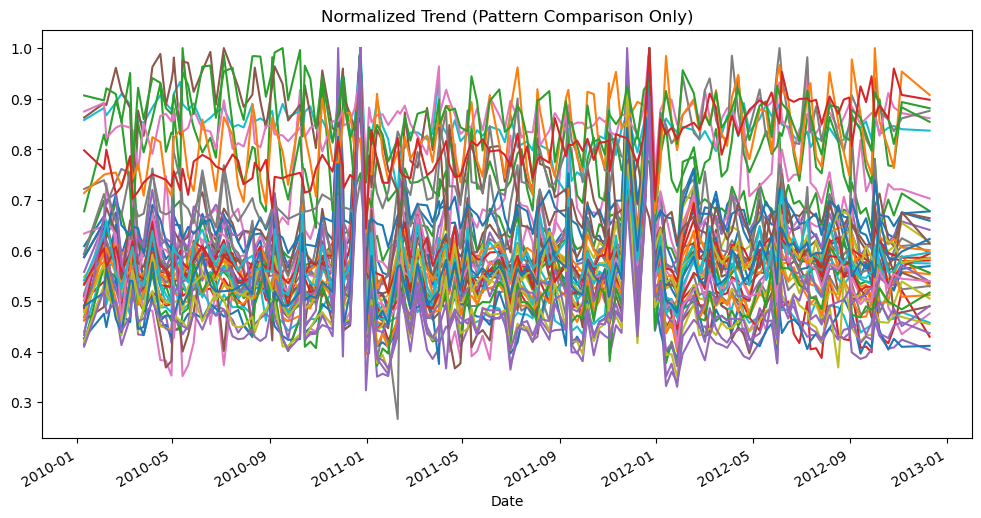

<Figure size 640x480 with 0 Axes>

In [9]:
# Show pattern across stores
pivot = df.pivot(index='Date', columns='Store', values='Weekly_Sales')
pivot_norm = pivot / pivot.max()

pivot_norm.plot(figsize=(12,6), legend=False)
plt.title("Normalized Trend (Pattern Comparison Only)")
plt.show()

# Save as PNG 
plt.savefig('pattern_comaprison.png', dpi=300, bbox_inches='tight')

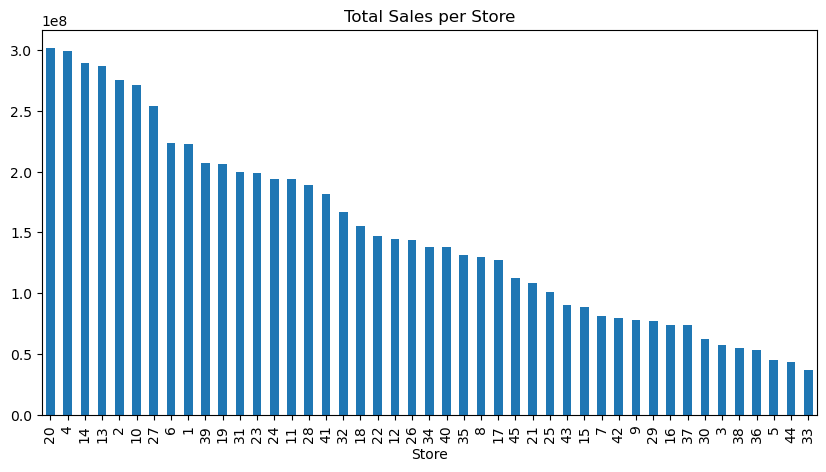

<Figure size 640x480 with 0 Axes>

In [10]:
# Store weekly sales comparison
total_sales = df.groupby('Store')['Weekly_Sales'].sum()
total_sales.sort_values(ascending = False).plot(kind='bar', figsize=(10,5))
plt.title("Total Sales per Store")
plt.show()

plt.savefig('sales_comparison_by_store.png', dpi=300, bbox_inches='tight')

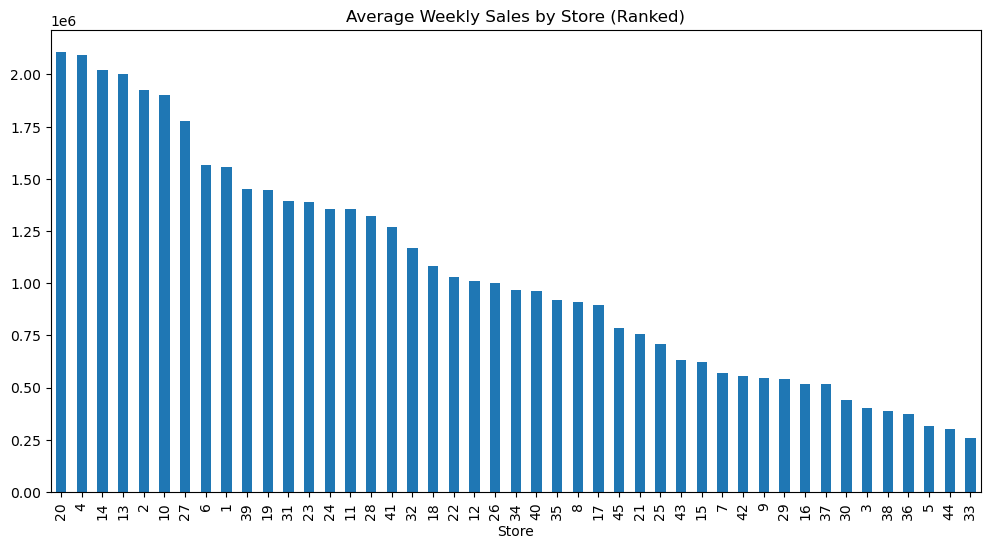

<Figure size 640x480 with 0 Axes>

In [11]:
# Average sales per store
avg_sales = df.groupby('Store')['Weekly_Sales'].mean()
avg_sales.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))

plt.title("Average Weekly Sales by Store (Ranked)")
plt.show()


plt.savefig('ranked_average_sales_per_store.png', dpi=300, bbox_inches='tight')


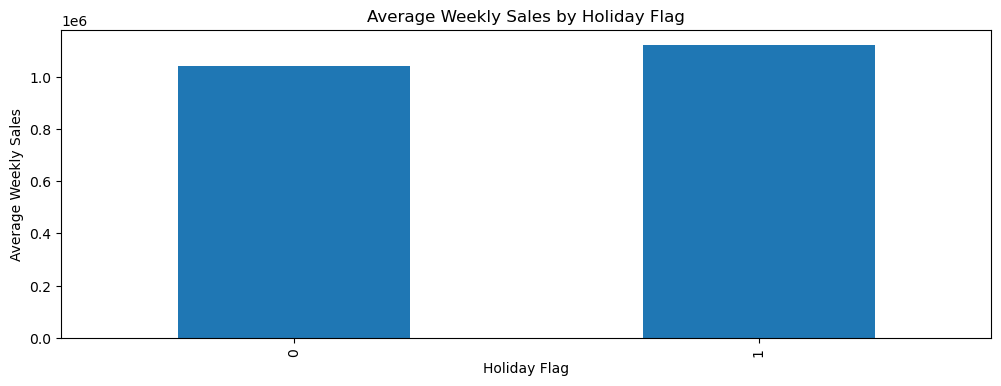

In [12]:
# Weekly sales by holiday flag

pt = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().plot(kind = 'bar', figsize=(12, 4))
plt.title("Average Weekly Sales by Holiday Flag")
plt.xlabel("Holiday Flag")
plt.ylabel("Average Weekly Sales")

# Save as PNG
plt.savefig('weekly_sales_by_holiday_flag.png', dpi=300, bbox_inches='tight')

### CORRELATION HEATMAP

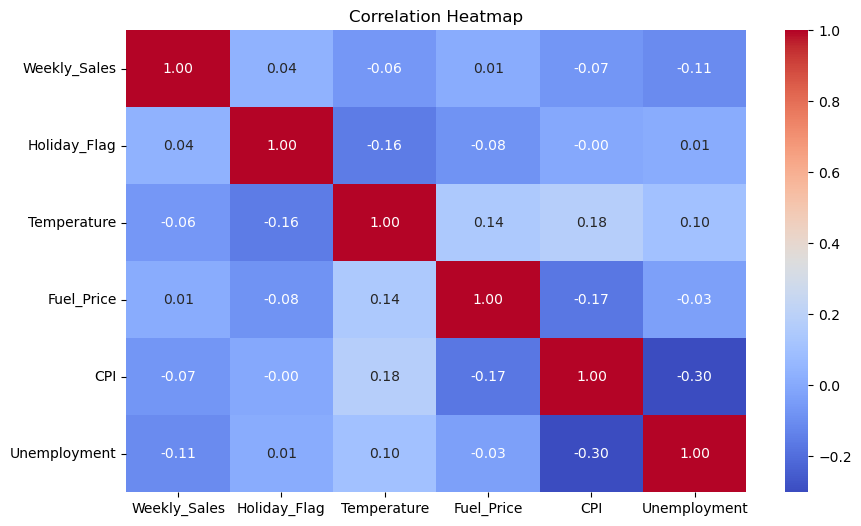

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot correlation heatmap

plt.figure(figsize=(10,6))
corr = df[['Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Save as PNG
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')

### MIXED EFFECT MODEL FOR ALL THE STORES

In [14]:

mixed_effect_model = smf.ols(
    formula="Weekly_Sales ~ C(Store) + Holiday_Flag + Temperature + Fuel_Price + CPI + Unemployment",
    data=df
).fit()

print(mixed_effect_model.summary())


                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     1500.
Date:                Mon, 17 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:16:06   Log-Likelihood:                -86222.
No. Observations:                6435   AIC:                         1.725e+05
Df Residuals:                    6385   BIC:                         1.729e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.278e+06   2.28e+05      5.

In [15]:
# To explain sales based differences, understand what features matter for each store
# Lag features (critical for per-store models)
df['Lag1'] = df.groupby("Store")['Weekly_Sales'].shift(1)
df['Lag2'] = df.groupby("Store")['Weekly_Sales'].shift(2)
df['MA4'] = df.groupby("Store")['Weekly_Sales'].rolling(4).mean().reset_index(level=0, drop=True)

for s in df.Store.unique():
    store_df = df[df.Store == s].dropna()

    model = smf.ols(
        "Weekly_Sales ~ Holiday_Flag + Temperature + Fuel_Price + CPI + Unemployment + Week_num + Month + Lag1 + MA4",
        data=store_df
    ).fit()

    print(f"\n=== Store {s} ===")
    print(model.rsquared)
    print(model.summary())



=== Store 5 ===
0.4771373735855715
                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     13.18
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           8.45e-15
Time:                        09:16:06   Log-Likelihood:                -1629.1
No. Observations:                 140   AIC:                             3278.
Df Residuals:                     130   BIC:                             3308.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept   

### FORECASTING WITH PROPHET FOR WEEKLY SALES WITH CONFIDENCE INTERVALS AND AGGREGATE N WEEKS 

In [66]:
# Sort store and date
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

# Add external regressors
regressors = ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Train prophet model per store with regressors
store_ids = df['Store'].unique()

models = {}
forecasts = {}
metrics = []
all_forecasts = []

for store in store_ids:
    df_store = df[df['Store'] == store][['Date', 'Weekly_Sales'] + regressors].copy()
    df_store = df_store.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
    
    # Initialize model
    prophet_model = Prophet(interval_width=0.90)
    
    # Add regressors
    for reg in regressors:
        prophet_model.add_regressor(reg)
    
    # Fit model
    prophet_model.fit(df_store)
    
    # Create future periods (30 weeks)
    future = prophet_model.make_future_dataframe(periods=30, freq='W')
    
    # Merge regressor values for future dates (forward fill)
    future = future.merge(df_store[['ds'] + regressors], on='ds', how='left')
    future[regressors] = future[regressors].ffill()
    
    # Forecast
    forecast = prophet_model.predict(future)
    
    # Save
    #models[store] = prophet_model
    #forecasts[store] = forecast
    
    # Extract the future weekly forecasts with confidence intervals
    future_weeks = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30).copy()
    future_weeks['Store'] = store
    
    # Save
    models[store] = prophet_model
    forecasts[store] = future_weeks
    
    # Compute summary stat for ranking (optional)
    avg_pred = future_weeks['yhat'].mean()
    metrics.append([store, avg_pred])
    
    # Save for combination
    all_forecasts.append(future_weeks)


final_weekly_forecast = pd.concat(all_forecasts, ignore_index=True)
display(final_weekly_forecast)

#display(future_weeks.style.format({
    #'yhat': '{:,.0f}',
    #'yhat_lower': '{:,.0f}',
    #'yhat_upper': '{:,.0f}'
#}))


# Ranking table
ranking_df['Avg_Forecast'] = ranking_df['Avg_Forecast'].round(0).astype(int)
ranking_df.style.format({'Avg_Forecast': '{:,.0f}'})
#ranking_df


18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
18:00:43 - cmdstanpy - INFO - Chain [1] start processing
18:00:43 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:44 - cmdstanpy - INFO - Chain [1] done processing
18:00:44 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:45 - cmdstanpy - INFO - Chain [1] done processing
18:00:45 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1] done processing
18:00:46 - cmdstanpy - INFO - Chain [1] start processing
18:00:46 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,Store
0,2012-12-16,1.965789e+06,1.789946e+06,2.151611e+06,1
1,2012-12-23,2.035026e+06,1.848213e+06,2.209226e+06,1
2,2012-12-30,1.924012e+06,1.750757e+06,2.096416e+06,1
3,2013-01-06,1.680385e+06,1.507775e+06,1.851582e+06,1
4,2013-01-13,1.474093e+06,1.301910e+06,1.652946e+06,1
...,...,...,...,...,...
1345,2013-06-09,7.767760e+05,6.355591e+05,9.276518e+05,45
1346,2013-06-16,7.953842e+05,6.459097e+05,9.521951e+05,45
1347,2013-06-23,7.906149e+05,6.526374e+05,9.437658e+05,45
1348,2013-06-30,7.515295e+05,5.949623e+05,9.056859e+05,45


,Store,Avg_Forecast
19,20,"2,216,582"
3,4,"2,216,365"
1,2,"2,092,742"
12,13,"2,035,235"
9,10,"1,812,956"
0,1,"1,736,156"
26,27,"1,725,476"
5,6,"1,707,850"
13,14,"1,685,260"
38,39,"1,627,381"


In [33]:
mixed_effect_summary = pd.read_html(mixed_effect_model.summary().tables[1].as_html(), header=0, index_col=0)[0]
mixed_effect_summary.to_csv("mixed_effects_coefficients.csv")

final_weekly_forecast.to_csv("store_weekly_forecast.csv", index=False)
ranking_df.to_csv("store_rankings.csv", index=False)



C:\Users\omary\AppData\Local\Temp\ipykernel_10980\864621645.py:1: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mixed_effect_summary = pd.read_html(mixed_effect_model.summary().tables[1].as_html(), header=0, index_col=0)[0]


In [ ]:
# Historical data
hist = df[['ds', 'weekly_sales', 'store']].copy()


hist['forecast'] = None
hist['forecast_lower'] = None
hist['forecast_upper'] = None
hist['Store'] = store
hist['Type'] = 'Historical'

# Forecast data
final_forecast = final_weekly_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Rename forecast columns
final_forecast.rename(columns={
    'yhat': 'forecast',
    'yhat_lower': 'forecast_lower',
    'yhat_upper': 'forecast_upper'
}, inplace=True)

# No actual sales for forecast rows
final_forecast['sales'] = None

final_forecast['Store'] = store
final_forecast['Type'] = 'Forecast'

# Combine
combined = pd.concat([hist, final_forecast], ignore_index=True)

# Save
combined.to_csv(f"store_{store}_forecast.csv", index=False)



In [70]:
# Historical data
hist = df[['Date', 'Weekly_Sales', 'Store', 'Holiday_Flag', 'Temperature',
             'Fuel_Price', 'CPI', 'Unemployment', 'Week_num', 'Year']].copy()
hist['forecast'] = None
hist['forecast_lower'] = None
hist['forecast_upper'] = None
#hist['Store'] = store
hist['Type'] = 'Historical'

# Forecast data
final_forecast = final_weekly_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','Store']].copy()

# Rename forecast columns
final_forecast.rename(columns={
    'ds': 'Date',
    'yhat': 'forecast',
    'yhat_lower': 'forecast_lower',
    'yhat_upper': 'forecast_upper'
}, inplace=True)
final_forecast['Type'] = 'Forecast'

# Combine
combined = pd.concat([hist, final_forecast], ignore_index=True)

# Save
combined.to_csv(f"walmart_Historical+forecast.csv", index=False)
combined

C:\Users\omary\AppData\Local\Temp\ipykernel_10980\1076650688.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined = pd.concat([hist, final_forecast], ignore_index=True)


,Date,Weekly_Sales,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week_num,Year,forecast,forecast_lower,forecast_upper,Type
0,2010-01-10,1453329.50,1,0.0,71.89,2.603,211.671989,7.838,3.0,2010.0,NaN,NaN,NaN,Historical
1,2010-02-04,1594968.28,1,0.0,62.27,2.719,210.820450,7.808,6.0,2010.0,NaN,NaN,NaN,Historical
2,2010-02-07,1492418.14,1,0.0,80.91,2.669,211.223533,7.787,7.0,2010.0,NaN,NaN,NaN,Historical
3,2010-02-19,1611968.17,1,0.0,39.93,2.514,211.289143,8.106,8.0,2010.0,NaN,NaN,NaN,Historical
4,2010-02-26,1409727.59,1,0.0,46.63,2.561,211.319643,8.106,9.0,2010.0,NaN,NaN,NaN,Historical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7780,2013-06-09,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776775.999777,635559.072747,927651.774679,Forecast
7781,2013-06-16,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,795384.221162,645909.697329,952195.117144,Forecast
7782,2013-06-23,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790614.921064,652637.373637,943765.754589,Forecast
7783,2013-06-30,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,751529.453673,594962.300212,905685.914685,Forecast
